# RNN Notebook

Notebook made for the RNN part of the assignment. Will contain all preprocessing and such, as well as implementation.

This is a placeholder cell, code will follow later.

In [1]:
# Importing libraries to work with
import re
import os
import nltk
import spacy
import torch
import shutil
import random
import numpy as np
import scipy as sci
import polars as pl
import pandas as pd
import gensim as gns
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# For the sake of Preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Word Embedding
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Sklearn
from sklearn.decomposition import PCA

In [2]:
# Display the libraries' versions used in this notebook
version_list = {"NumPy Version:": np.__version__,
                "Polars Version:": pl.__version__,
                "MatPlotLib Version:": mpl.__version__,
                "Seaborn Version:": sns.__version__,
                "PyTorch Version:": torch.__version__,
                "NLTK Version:": nltk.__version__,
                "SpaCy Version:": spacy.__version__,
                "Gensim Version:": gns.__version__,
                "SciPy Version:": sci.__version__}

for (k, v) in version_list.items():
    print(k, v)

NumPy Version: 1.26.4
Polars Version: 1.16.0
MatPlotLib Version: 3.9.3
Seaborn Version: 0.13.2
PyTorch Version: 2.5.1+cpu
NLTK Version: 3.9.1
SpaCy Version: 3.8.2
Gensim Version: 4.3.3
SciPy Version: 1.13.1


In [3]:
# Defining path to install NLTK libraries in
NLTK_LIB_PATH = os.path.join("..", "venv_nlp", "Lib", "nltk_data")

# Defining download function
def download_libs():
    libraries = {
        "corpora\\stopwords": "stopwords",
        "corpora\\wordnet": "wordnet"
    }

    for resource, package in libraries.items():
        try:
            nltk.data.find(resource)
            print(f"{package.capitalize()} data exists.")
        except LookupError:
            print(f"Downloading {package}...")

            # Handle potential corrupted files
            resource_path = os.path.join(NLTK_LIB_PATH, *resource.split('\\'))
            if os.path.exists(resource_path):
                print(f"Removing corrupted file: {resource_path}")
                try:
                    shutil.rmtree(resource_path) if os.path.isdir(resource_path) else os.remove(resource_path)
                except Exception as e:
                    print(f"Error removing corrupted file {resource_path}: {e}")
            # Attempt download again
            nltk.download(package, download_dir=NLTK_LIB_PATH)
        except Exception as e:
            print(f"Unexpected error checking {package}: {e}")

In [4]:
try:
    os.makedirs(NLTK_LIB_PATH, exist_ok=True)
    print(f"Using NLTK data directory: {NLTK_LIB_PATH}")
    download_libs()
except PermissionError:
    print(f"Permission denied: Unable to create or write to directory '{NLTK_LIB_PATH}'")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Using NLTK data directory: ..\venv_nlp\Lib\nltk_data
Stopwords data exists.
Wordnet data exists.


# Data Loading

In [5]:
reviews = pl.read_csv("../data/IMDB Dataset.csv")

In [6]:
reviews.head(10)

review,sentiment
str,str
"""One of the other reviewers has…","""positive"""
"""A wonderful little production.…","""positive"""
"""I thought this was a wonderful…","""positive"""
"""Basically there's a family whe…","""negative"""
"""Petter Mattei's ""Love in the T…","""positive"""
"""Probably my all-time favorite …","""positive"""
"""I sure would like to see a res…","""positive"""
"""This show was an amazing, fres…","""negative"""
"""Encouraged by the positive com…","""negative"""


In [7]:
reviews.describe()

statistic,review,sentiment
str,str,str
"""count""","""50000""","""50000"""
"""null_count""","""0""","""0"""
"""mean""",null,null
"""std""",null,null
"""min""","""A Turkish Bath sequence in…","""negative"""
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""ý thýnk uzak ýs the one of the…","""positive"""


# Preprocessing

In [8]:
# Create a stopword set
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add("im")

In [9]:
# Define a regex function to remove special characters, links, etc.
def regex_cleanse(text: str):
    # URLS
    text = re.sub(r'https\S+', '', text)

    # @<username>
    text = re.sub(r'@\w+', '', text)

    # Non-alphabet character
    text = re.sub(r'[^a-zA-Z ]', '', text)

    # #<word>
    text = re.sub(r'#\w+', '', text)

    # One character that doesn't belong to word or whitespace
    text = re.sub(r'[^\w\s]', '', text)

    # Attempt to remove linked pictures URLs
    text = re.sub(r'pic\w+', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords])

    return text

In [10]:
# Loading language model
model_language_spacy = spacy.load('en_core_web_sm')

# Lemmatiser
def lemma(tokens):
    doc = model_language_spacy(tokens)
    return [token.lemma_ for token in doc]

In [11]:
# Removing emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [12]:
# Define a text preprocessing function to apply to all rows
def preprocess_text(text: str) -> list[str]:
    text = regex_cleanse(text.lower())
    text = remove_emoji(text)
    text = lemma(text)

    return text

In [13]:
# Creating a cleaned-preprocessed dataset
#cleaned = reviews.with_columns(pl.col('review').map_elements(preprocess_text, return_dtype = list[str]))
cleaned = pl.read_ndjson('../data/imdb_clean.json')

In [14]:
cleaned.head()

review,sentiment
list[str],str
"[""one"", ""reviewer"", … ""side""]","""positive"""
"[""wonderful"", ""little"", … ""do""]","""positive"""
"[""think"", ""wonderful"", … ""friend""]","""positive"""
"[""basically"", ""there"", … ""ignore""]","""negative"""
"[""petter"", ""matteis"", … ""work""]","""positive"""


In [15]:
cleaned.write_ndjson(file = '../data/imdb_clean.json')

# Word Embedding

In [16]:
# Creating a series of lists to be parsed into a vector
# I will be using a skipgram Word2Vec model
embedding_text = cleaned['review'].to_list()

embedding_text[0][:5]

['one', 'reviewer', 'mention', 'watch', 'oz']

In [17]:
#w2v_skipgram = Word2Vec(embedding_text, vector_size = 100, sg = 1, workers = 10, window = 32, epochs = 5)

In [18]:
# Saving the w2v model for later use
#w2v_skipgram.save("../wordembed/w2v_sg.model")

w2v_skipgram = Word2Vec.load('../wordembed/w2v_sg.model')

In [19]:
w2v_skipgram.wv['horror']

array([-0.01050346,  0.24950458,  0.05217788, -0.29049224,  0.04847969,
        0.03122034,  0.34357744,  0.39543572, -0.15848024, -0.17656553,
        0.27617827, -0.06074983,  0.19527179, -0.19398004,  0.24254476,
       -0.33821297, -0.04195563, -0.12653409,  0.12984906,  0.06021116,
        0.11972744, -0.0044531 ,  0.03778375, -0.4925069 , -0.2229252 ,
        0.35034776,  0.17614731, -0.3828557 ,  0.33748838,  0.14423443,
        0.47120342, -0.42818165, -0.12849556, -0.14396049,  0.40705243,
       -0.09162427,  0.01340964,  0.09601955, -0.07237893,  0.10251185,
       -0.21528737, -0.26008555, -0.09586003,  0.0145961 , -0.11169808,
       -0.12389541,  0.15784937, -0.2086932 , -0.18732902,  0.2399812 ,
        0.10241289, -0.38055202,  0.11384615, -0.07729186, -0.12073651,
        0.39402267,  0.2973257 ,  0.2719287 , -0.1140646 ,  0.28911892,
       -0.00432293,  0.042277  ,  0.02128095,  0.01653638,  0.09890844,
       -0.4481542 ,  0.35383353,  0.24400412, -0.07474237,  0.07

In [20]:
w2v_skipgram.wv.most_similar('horror', topn = 10)

[('scary', 0.795227587223053),
 ('bhorror', 0.7904592752456665),
 ('scare', 0.7766833305358887),
 ('slasher', 0.772209882736206),
 ('gorebut', 0.770581841468811),
 ('changele', 0.761751115322113),
 ('lossessa', 0.760185182094574),
 ('candyman', 0.7597736716270447),
 ('flick', 0.7561708092689514),
 ('amityville', 0.7520821690559387)]

In [21]:
vocab_size = w2v_skipgram.wv.__len__() + 1

# Implementing the RNN Class

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [23]:
# Define hyper params for later use
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 2
EPOCHS = 15
BATCH_SIZE = 100
LR = 0.001
MAX_SEQ_LEN = 40

In [24]:
def class_to_num(sentiment):
    return 1 if sentiment == "positive" else 0

loadable_data = cleaned.with_columns(
    pl.col("sentiment").map_elements(class_to_num, return_dtype = int)
)

loadable_data.head()

review,sentiment
list[str],i64
"[""one"", ""reviewer"", … ""side""]",1
"[""wonderful"", ""little"", … ""do""]",1
"[""think"", ""wonderful"", … ""friend""]",1
"[""basically"", ""there"", … ""ignore""]",0
"[""petter"", ""matteis"", … ""work""]",1


In [25]:
def review_to_embedding(review, max_seq_len, embedding_dim):
    embeddings = [
        w2v_skipgram.wv[word] if word in w2v_skipgram.wv else np.zeros(embedding_dim)
        for word in review
    ]
    embeddings = embeddings[:max_seq_len]  # Truncate
    # Pad with zeros if shorter than max_seq_len
    if len(embeddings) < max_seq_len:
        embeddings += [np.zeros(embedding_dim)] * (max_seq_len - len(embeddings))
    return np.array(embeddings, dtype=np.float32)

In [26]:
loadable_data = loadable_data.with_columns(
    pl.col("review").map_elements(lambda x: review_to_embedding(x, MAX_SEQ_LEN, EMBEDDING_DIM), return_dtype = list[list[float]])
)

In [27]:
# Should save data here (HORRIBLE IDEA ~5GB)
#loadable_data.write_ndjson('../data/imdb_embedded.json')

In [28]:
#loadable_data = pl.read_ndjson('../data/imdb_embedded.json')

loadable_data.head()

review,sentiment
list[list[f64]],i64
"[[0.053646, 0.169129, … -0.117089], [0.059409, 0.257952, … -0.150777], … [0.237985, 0.285544, … 0.107752]]",1
"[[0.069264, 0.210273, … -0.045096], [-0.046261, 0.047188, … -0.098948], … [0.039598, -0.053692, … -0.114939]]",1
"[[0.07442, 0.106315, … -0.042415], [0.069264, 0.210273, … -0.045096], … [0.042387, 0.08614, … -0.150596]]",1
"[[-0.073931, 0.041117, … -0.132843], [-0.067784, -0.000722, … -0.014203], … [-0.013528, 0.08617, … -0.264038]]",0
"[[0.0, 0.0, … 0.0], [0.185396, 0.459882, … -0.617428], … [0.124108, 0.039394, … -0.057854]]",1


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    loadable_data["review"],
    loadable_data["sentiment"],
    test_size=0.2,
    random_state=42
)

In [30]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

In [31]:
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, dropout=0.5):
        super(SentimentRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        hidden = self.layer_norm(hidden.squeeze(0))
        out = self.fc(hidden)
        return out


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [34]:
# Initialize model
rnn_model_sentiment = SentimentRNN(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model_sentiment.parameters(), lr=LR)

In [35]:
# Training loop with testing
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    # Training phase
    rnn_model_sentiment.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = rnn_model_sentiment(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing phase
    rnn_model_sentiment.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = rnn_model_sentiment(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Print epoch stats
    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Save losses for graphing
torch.save({"train": train_losses, "test": test_losses}, "../model_instances/RNN/losses.pt")

# Save the trained model
torch.save(rnn_model_sentiment.state_dict(), "../model_instances/RNN/sentiment_rnn.pth")

print("Training and testing complete!")


Epoch 1/15, Train Loss: 0.5095, Test Loss: 0.4971
Epoch 2/15, Train Loss: 0.4677, Test Loss: 0.4507
Epoch 3/15, Train Loss: 0.4644, Test Loss: 0.4656
Epoch 4/15, Train Loss: 0.4404, Test Loss: 0.4435
Epoch 5/15, Train Loss: 0.4267, Test Loss: 0.4353
Epoch 6/15, Train Loss: 0.4163, Test Loss: 0.4677
Epoch 7/15, Train Loss: 0.4197, Test Loss: 0.4335
Epoch 8/15, Train Loss: 0.4165, Test Loss: 0.4199
Epoch 9/15, Train Loss: 0.4155, Test Loss: 0.4107
Epoch 10/15, Train Loss: 0.4167, Test Loss: 0.4124
Epoch 11/15, Train Loss: 0.4100, Test Loss: 0.4163
Epoch 12/15, Train Loss: 0.4091, Test Loss: 0.4489
Epoch 13/15, Train Loss: 0.4082, Test Loss: 0.4064
Epoch 14/15, Train Loss: 0.4066, Test Loss: 0.4071
Epoch 15/15, Train Loss: 0.4071, Test Loss: 0.4164
Training and testing complete!


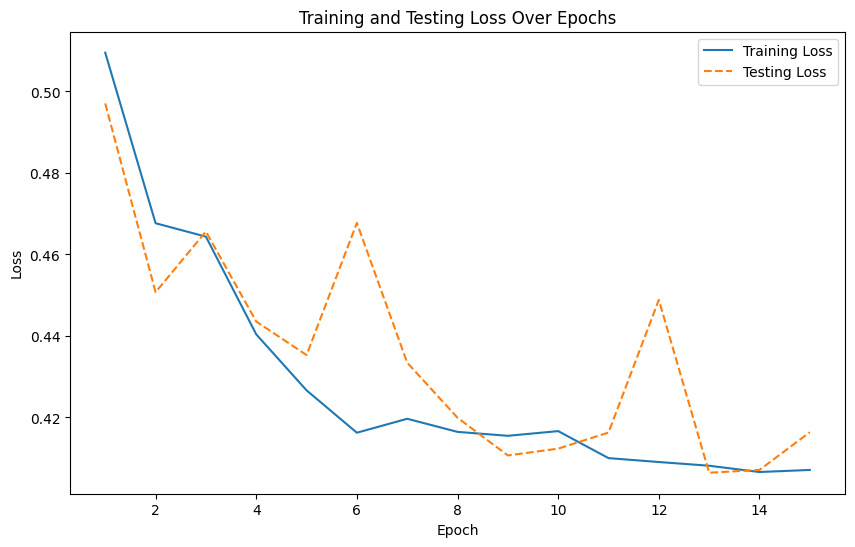

In [36]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.legend()
plt.show()


# Text Summarisation Task

In [140]:
data_path = '../data/news/article_highlights.csv'
data = pl.read_csv(data_path)
data = data.drop_nulls()
print(data.head())

shape: (5, 3)
┌────────────────────────────────┬────────────────────────────────┬────────────────────────────────┐
│ url                            ┆ article                        ┆ highlights                     │
│ ---                            ┆ ---                            ┆ ---                            │
│ str                            ┆ str                            ┆ str                            │
╞════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ https://www.dailymail.co.uk/tv ┆ Beyoncé showcases her          ┆ Beyoncé has shown off her      │
│ …                              ┆ incredib…                      ┆ flaw…                          │
│ https://www.dailymail.co.uk/tv ┆ Radio 1 listeners in shock as  ┆ BBC Radio 1 listeners were     │
│ …                              ┆ …                              ┆ lef…                           │
│ https://www.dailymail.co.uk/tv ┆ TOWIE's Dan Edgar, 33, and     ┆ Dan Edgar

In [141]:
data = data.drop(data.columns[0])
data = data.rename({data.columns[0]: "text", data.columns[1]: "headline"})

In [142]:
data.head()

text,headline
str,str
"""Beyoncé showcases her incredib…","""Beyoncé has shown off her flaw…"
"""Radio 1 listeners in shock as …","""BBC Radio 1 listeners were lef…"
"""TOWIE's Dan Edgar, 33, and Ell…","""Dan Edgar and Ella Rae Wise pu…"
"""Bradley Cooper recalls 'crazy'…","""Bradley Cooper discussed the '…"
"""Margaret Qualley and Beanie Fe…","""Margaret Qualley and Beanie Fe…"


In [143]:
data_processed = data.with_columns(
    pl.col('text').map_elements(preprocess_text, return_dtype = list[str]))

data_processed.head()

text,headline
list[str],str
"[""beyonc"", ""showcase"", … ""range""]","""Beyoncé has shown off her flaw…"
"[""radio"", ""listener"", … ""airwave""]","""BBC Radio 1 listeners were lef…"
"[""towie"", ""dan"", … ""series""]","""Dan Edgar and Ella Rae Wise pu…"
"[""bradley"", ""cooper"", … ""role""]","""Bradley Cooper discussed the '…"
"[""margaret"", ""qualley"", … ""doll""]","""Margaret Qualley and Beanie Fe…"


In [144]:
w2v_summarise_text = Word2Vec(data_processed['text'].to_list(), vector_size = 100, sg = 1, workers = 10, window = 32, epochs = 5)
w2v_summarise_headline = Word2Vec(data_processed['headline'].to_list(), vector_size = 100, sg = 1, workers = 10, window = 32, epochs = 5)

In [145]:
def txt_head_to_embedding(review, max_seq_len, embedding_dim, model):
    embeddings = [
        model.wv[word] if word in model.wv else np.zeros(embedding_dim)
        for word in review
    ]
    embeddings = embeddings[:max_seq_len]  # Truncate
    # Pad with zeros if shorter than max_seq_len
    if len(embeddings) < max_seq_len:
        embeddings += [np.zeros(embedding_dim)] * (max_seq_len - len(embeddings))
    return np.array(embeddings, dtype=np.float32)

In [146]:
# Model parameters
input_size = 100  # Word2Vec vector size
hidden_size = 128
output_size = 100  # Word2Vec vector size
max_seq_len = 32
epochs = 10
batch_size = 32
learning_rate = 0.001

In [147]:
data_embeded = data_processed.with_columns(
    pl.col("text").map_elements(lambda x: txt_head_to_embedding(x, 32, 100, w2v_summarise_text), return_dtype=list[list[float]]),
    pl.col("headline").map_elements(lambda x: txt_head_to_embedding(x, 32, 100, w2v_summarise_headline), return_dtype=list[list[float]])
)

In [148]:
print(data_embeded.head())

shape: (5, 2)
┌─────────────────────────────────┬─────────────────────────────────┐
│ text                            ┆ headline                        │
│ ---                             ┆ ---                             │
│ list[list[f64]]                 ┆ list[list[f64]]                 │
╞═════════════════════════════════╪═════════════════════════════════╡
│ [[-0.114609, -0.146333, … 0.40… ┆ [[-0.114707, -0.197579, … -0.0… │
│ [[-0.637115, -0.18626, … 0.045… ┆ [[-0.114707, -0.197579, … -0.0… │
│ [[-0.307714, 0.521526, … 0.050… ┆ [[0.041785, 0.034237, … -0.068… │
│ [[-0.225032, -0.099123, … 0.04… ┆ [[-0.114707, -0.197579, … -0.0… │
│ [[-0.449703, -0.009097, … -0.0… ┆ [[0.090821, 0.211195, … -0.156… │
└─────────────────────────────────┴─────────────────────────────────┘


In [149]:
train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data_embeded['text'], data_embeded['headline'],
                                         test_size=0.2, random_state=42)

In [150]:
class TextSummarizerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_seq_len):
        super(TextSummarizerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.max_seq_len = max_seq_len

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.output_projection = nn.Linear(output_size, output_size * max_seq_len)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        _, hidden = self.rnn(x)
        # hidden shape: [1, batch_size, hidden_size]

        hidden = self.layer_norm(hidden.squeeze(0))
        # hidden shape: [batch_size, hidden_size]

        decoded = self.decoder(hidden)
        # decoded shape: [batch_size, output_size]

        output = self.output_projection(decoded)
        # reshape to match target shape
        output = output.view(-1, self.max_seq_len, output.size(-1) // self.max_seq_len)
        # output shape: [batch_size, max_seq_len, output_size]

        return output

In [152]:
rnn_model_summariser = TextSummarizerRNN(input_size, hidden_size, output_size, max_seq_len)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model_summariser.parameters(), lr=0.001)

In [153]:
class SummaryDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        self.texts = torch.tensor(data_x, dtype=torch.float32)
        self.headlines = torch.tensor(data_y, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.headlines[idx]

In [154]:
train_dataset = SummaryDataset(train_data_x, train_data_y)
test_dataset = SummaryDataset(test_data_x, test_data_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [155]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training Phase
    rnn_model_summariser.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = rnn_model_summariser(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Evaluation Phase
    rnn_model_summariser.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = rnn_model_summariser(inputs)
            loss = criterion(outputs, targets)
            epoch_test_loss += loss.item()

    test_losses.append(epoch_test_loss / len(test_loader))

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")


Epoch 1/10, Train Loss: 0.0100, Test Loss: 0.0067
Epoch 2/10, Train Loss: 0.0058, Test Loss: 0.0052
Epoch 3/10, Train Loss: 0.0045, Test Loss: 0.0033
Epoch 4/10, Train Loss: 0.0026, Test Loss: 0.0018
Epoch 5/10, Train Loss: 0.0016, Test Loss: 0.0014
Epoch 6/10, Train Loss: 0.0010, Test Loss: 0.0008
Epoch 7/10, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 8/10, Train Loss: 0.0005, Test Loss: 0.0004
Epoch 9/10, Train Loss: 0.0004, Test Loss: 0.0004
Epoch 10/10, Train Loss: 0.0003, Test Loss: 0.0002


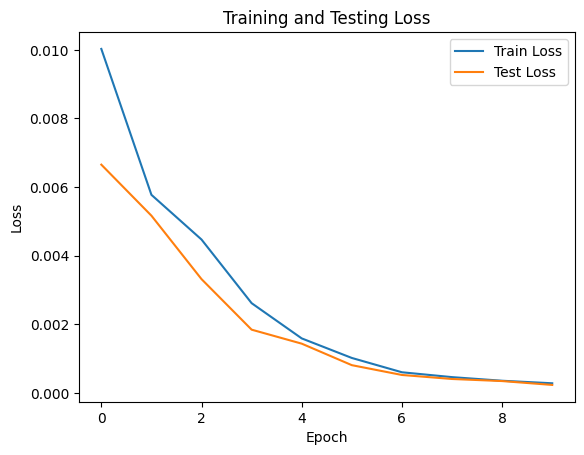

In [156]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()